In [1]:
%matplotlib inline
#Codes by Shucheng Yang
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pycbc.psd
from lib.PSD.LISAcalPSD import LISAcalPSD1, LISAcalPSD2 

from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
from pycbc import filter


from astropy import constants as const #import constants 
import astropy.units as u              #import unit

#my codes
from lib.waveform import get_td_waveform
from lib.waveform import peters
from lib.filter import compare
from lib.filter.compare import overlap_func
from lib.filter.compare import match_func

# 参数设置

In [2]:
sampFreq = 2**(-2)                #采样频率(Sampling frequency)，单位时间样本点个数，应大于 2f（即Nyquist频率)
duration = 2**25           #信号持续时间(duration of signal) 2^16, 0.75d, 2^25 ,1.06yr


n = int(duration * sampFreq)#采样点数(Sampling Number), 有时也称为信号长度(Length of Signal) 2^16
                            #为2的幂时，快速傅里叶变化效率最高
                            #n =  duration * sampFreqint = (duration / sampIntrvl)

sampIntrvl = 1.0 / sampFreq                   #采样周期(Sampling period)，隔多少时间取样一次，或步长
freqIntrvl = sampFreq / n                     #傅里叶变换 频率分辨率(Frequency Interval) 
                                              # freqIntrvl = 1 / duration = 1 / (n * sampIntrvl)
                                              #            = sampFreq / n  
        

f_max = sampFreq/2             #信号模式的最大频率

print("采样频率为%fHz，信号持续时间%ds, 时域信号采样%d 个点"%(sampFreq,duration,n))
print("信号中可分析最大频率为%fHz"%f_max)
print("\n采样周期，即时域分辨率为%fs"%(sampIntrvl))
print("信号频域的频率间隔，即频域分辨率为%fHz"%freqIntrvl);

采样频率为0.250000Hz，信号持续时间33554432s, 时域信号采样8388608 个点
信号中可分析最大频率为0.125000Hz

采样周期，即时域分辨率为4.000000s
信号频域的频率间隔，即频域分辨率为0.000000Hz


# PSD

/Users/ysc/codes/all/matchGW/lib/PSD/LISAcalPSD.py:40: RuntimeWarning: divide by zero encountered in true_divide
  r = (1/ u**2) * ( (1 + np.cos(u)**2) * (1/3 - 2/u**2) + np.sin(u)**2 + 4*np.sin(u)*np.cos(u)/(u**3) )
/Users/ysc/codes/all/matchGW/lib/PSD/LISAcalPSD.py:40: RuntimeWarning: invalid value encountered in true_divide
  r = (1/ u**2) * ( (1 + np.cos(u)**2) * (1/3 - 2/u**2) + np.sin(u)**2 + 4*np.sin(u)*np.cos(u)/(u**3) )
/Users/ysc/codes/all/matchGW/lib/PSD/LISAcalPSD.py:42: RuntimeWarning: divide by zero encountered in true_divide
  psd1 = (8.08e-48 / ((2*np.pi*freqVec)**4) + 5.52e-41)
/Users/ysc/codes/all/matchGW/lib/PSD/LISAcalPSD.py:43: RuntimeWarning: divide by zero encountered in true_divide
  psd2 = (2.88e-48 / ((2*np.pi*freqVec)**4) + 5.52e-41) / r
/Users/ysc/codes/all/matchGW/lib/PSD/LISAcalPSD.py:51: RuntimeWarning: invalid value encountered in multiply
  psd = psd1 * shadow1 + psd2 * shadow2


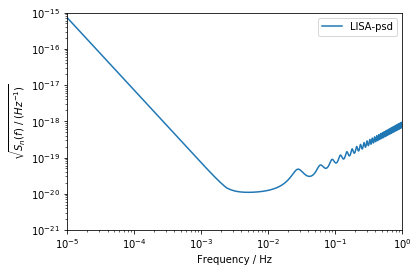

In [3]:
#注意： 会有除0警告，可以忽略
freqVec = np.linspace(0, 1, int(1/freqIntrvl))
#构建频率序列(必须等频率间隔)，这里我们开始于0Hz(必须开始于0，否则导入pyCBC的结果不对), 结束于1Hz，频率间隔为上面的freqIntrvl

#LISA PSD 模拟函数
psd = LISAcalPSD1(freqVec) 

'''
1. Babak, S., Fang, H., Gair, J. R., Glampedakis, K. & Hughes, S. A. Kludge’
gravitational waveforms for a test-body orbiting a Kerr black hole. Phys.Rev. D 75, 024005 (2007).

'''

#构建用于pyCBC的FrequencySeries
psd = FrequencySeries(psd, delta_f=freqIntrvl, epoch='', dtype=None, copy=True)

#绘制 频率 - sqrt(PSD) 图 
plt.figure()
plt.loglog(psd.sample_frequencies, np.sqrt(psd), label = 'LISA-psd')
plt.xlim(1e-5,1e0)
plt.ylim(1e-21,1e-15)
plt.xlabel("Frequency / Hz")
plt.ylabel("$\sqrt{S_{n}(f) \ / \ (Hz^{-1})}$")
plt.legend()
plt.show()

# 波形

In [4]:
G = (const.G).value # gravitational constant
C = (const.c).value # the speed of light

#peters
#   Parameters
n = np.arange(1,11,1)                   #the nth harmonic
print(n)


M = (1e6 * const.M_sun).to(u.kg).value  #the mass of system, kilogram
m = (1e1 * const.M_sun).to(u.kg).value  #the mass of small compact body, kilogram

########################
R_unit = (G * M / C**2)#                #the unit length in G = C = 1 system, metre
t_unit = R_unit / C    #                #the unit time in G = C = 1 system, second
########################

e = 0.7                                #eccentricity of orbit
p = 15 * R_unit                         #semi-latus rectum

a = p / (1 - e**2)                      #the semi-major axis of orbit, metre

D = (1.00 * u.Gpc).to('m').value

#   Time Vector                  
tb = 17542  * t_unit                 #end time, second
step = t_unit                           #step

[ 1  2  3  4  5  6  7  8  9 10]


In [5]:
import time
a1 = time.time()

In [6]:
wave = peters(n = n, M = M, m = m, e = e, a = a, D = D)
wave.calculate(duration = duration, delta_t = sampIntrvl)

hp, hc = get_td_waveform(template=wave)
b1 = time.time()
print("用时%fs"%(b1-a1))

用时308.509733s


In [7]:
a1 = time.time()

lambda_g = (1.6e13 * u.km).to('m').value#the compton wavelength of graviton
wave.add_dispersion(lambda_g)
hpd, hcd = get_td_waveform(template=wave)

b1 = time.time()
print("用时%fs"%(b1-a1))

用时16.239337s


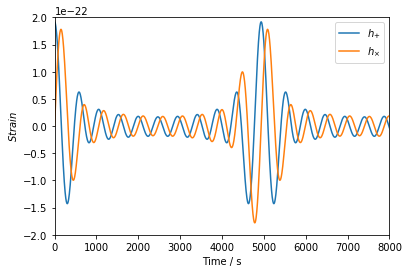

In [8]:
#绘制波形图 
plt.figure()
plt.plot(hp.sample_times, hp, label = '$h_{+}$')
plt.plot(hp.sample_times, hc, label = '$h_{\\times}$')
plt.xlim(0,8e3)
plt.ylim(- 2e-22,2e-22)
plt.xlabel("Time / s")
plt.ylabel("$Strain$")
plt.legend()
plt.show()

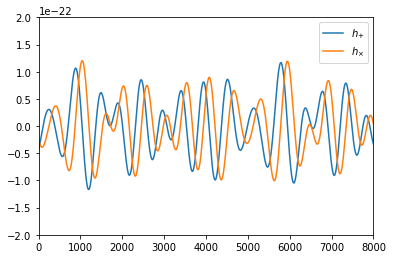

In [9]:
#绘制 波形图 
plt.figure()
plt.plot(hpd.sample_times, hpd, label = '$h_{+}$')
plt.plot(hpd.sample_times, hcd, label = '$h_{\\times}$')
plt.xlim(0,8e3)
plt.ylim(- 2e-22,2e-22)
# plt.xlabel("Time / s")
# plt.ylabel("$Strain$")
plt.legend()
plt.show()

# match and overlap

In [10]:
#定义波形模板函数，

def func(para, wave_instance = wave): #输入要调整的参数para，输出时间序列
    wave_instance.add_dispersion(para)
    return wave_instance.hplus


#定义匹配函数

overlap_cbc = lambda x,y: overlap_func(x, y, psd, sampIntrvl, 1e-4, f_max) #data, temp, psd, dt, f_min, f_max
match_cbc = lambda x,y: match_func(x, y, psd, sampIntrvl, 1e-4, f_max)


#定义参数
lambda_g0 = (1.6e13 * u.km).to('m').value #the compton wavelength of graviton
lambda_g_list = 10**(np.linspace(-2,4,30)) * lambda_g0 


#定义compare实例
peters_compare = compare(hp)                  #添加数据
peters_compare.template(lambda_g_list, func)  #添加模板和参数变动范围


peters_compare.calculate(overlap_cbc)         #计算overlap
overlap_list = peters_compare.result

peters_compare.calculate(match_cbc)           #计算match
match_list = peters_compare.result

# 结果展示

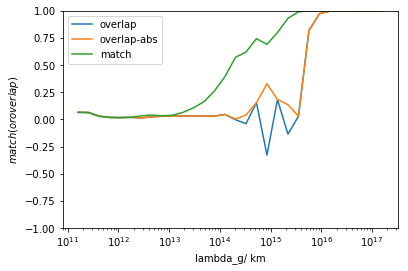

In [11]:
#绘制 波形图 
plt.figure()
plt.xscale("log")
plt.plot(lambda_g_list/1e3, overlap_list, label = 'overlap')
plt.plot(lambda_g_list/1e3, np.abs(overlap_list), label = 'overlap-abs')
plt.plot(lambda_g_list/1e3, match_list, label = 'match')
plt.ylim(-1,1)
plt.xlabel("lambda_g/ km")
plt.ylabel("$match(or overlap)$")
plt.legend()
plt.show()

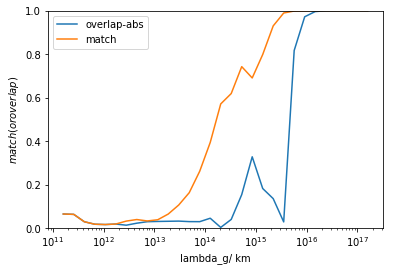

In [12]:
#绘制 波形图 
plt.figure()
plt.xscale("log")
# plt.plot(lambda_g_list/1e3, overlap_list, label = 'overlap')
plt.plot(lambda_g_list/1e3, np.abs(overlap_list), label = 'overlap-abs')
plt.plot(lambda_g_list/1e3, match_list, label = 'match')
plt.ylim(0,1)
plt.xlabel("lambda_g/ km")
plt.ylabel("$match(or overlap)$")
plt.legend()
plt.show()